https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/home/anvar/CC GENERAL.csv')
df.dropna(inplace=True)
df.head(3)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.0,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12


In [3]:
columns = df.columns
X = df[columns[1:]]

In [4]:
X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)
X_centered = X - X.mean(axis=0)

# Try KMeans with different K

In [5]:
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import numpy as np

In [6]:
inertia = []
results_df = pd.DataFrame()
clusters = range(2, 21)

for k in tqdm(clusters):
    
    # original
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    results_df[f'clusters_kmeans_{k}'] = kmeans.predict(X)
   
    # standardized
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_standardized)
    results_df[f'clusters_kmeans_std{k}'] = kmeans.predict(X_standardized)
    inertia.append(kmeans.inertia_)
    
    # centered
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_centered)
    results_df[f'clusters_kmeans_center{k}'] = kmeans.predict(X_centered)

100%|██████████| 19/19 [00:20<00:00,  1.07s/it]


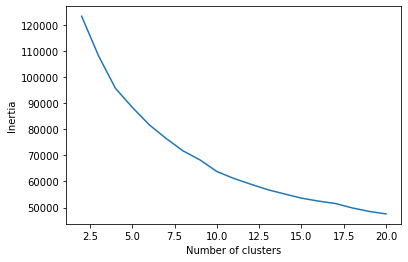

In [7]:
plt.plot(clusters, inertia);
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

In [8]:
k = 8
print(adjusted_rand_score(results_df[f'clusters_kmeans_std{k}'], results_df[f'clusters_kmeans_{k}']))

0.12316643850927815


In [9]:
k = 8
print(adjusted_rand_score(results_df[f'clusters_kmeans_std{k}'], results_df[f'clusters_kmeans_center{k}']))

0.12366228303588407


In [10]:
results_df['clusters_kmeans_std8'].value_counts().sort_index()

0    1069
1    1965
2    2651
3     839
4     412
5     588
6    1082
7      30
Name: clusters_kmeans_std8, dtype: int64

In [11]:
df[(results_df['clusters_kmeans_std8'] == 0).values].mean()

BALANCE                              134.209470
BALANCE_FREQUENCY                      0.428909
PURCHASES                            368.030374
ONEOFF_PURCHASES                     218.495463
INSTALLMENTS_PURCHASES               149.812554
CASH_ADVANCE                         328.844623
PURCHASES_FREQUENCY                    0.270649
ONEOFF_PURCHASES_FREQUENCY             0.077554
PURCHASES_INSTALLMENTS_FREQUENCY       0.185443
CASH_ADVANCE_FREQUENCY                 0.033785
CASH_ADVANCE_TRX                       0.729654
PURCHASES_TRX                          4.474275
CREDIT_LIMIT                        3902.188442
PAYMENTS                            1328.360767
MINIMUM_PAYMENTS                     162.350261
PRC_FULL_PAYMENT                       0.277429
TENURE                                11.809167
dtype: float64

In [12]:
df[(results_df['clusters_kmeans_std8'] == 2).values].mean()

BALANCE                             1621.705378
BALANCE_FREQUENCY                      0.976517
PURCHASES                            228.694447
ONEOFF_PURCHASES                     180.069959
INSTALLMENTS_PURCHASES                48.811166
CASH_ADVANCE                         797.895185
PURCHASES_FREQUENCY                    0.142807
ONEOFF_PURCHASES_FREQUENCY             0.079863
PURCHASES_INSTALLMENTS_FREQUENCY       0.063831
CASH_ADVANCE_FREQUENCY                 0.159815
CASH_ADVANCE_TRX                       3.140324
PURCHASES_TRX                          2.632214
CREDIT_LIMIT                        3379.391425
PAYMENTS                            1032.685745
MINIMUM_PAYMENTS                     860.940670
PRC_FULL_PAYMENT                       0.020302
TENURE                                11.881554
dtype: float64

# Hierarchical clustering

In [13]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=10,
                             affinity='euclidean',
                             linkage='single')

prediction = ac.fit_predict(X_standardized)
np.unique(prediction, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([8627,    1,    1,    1,    1,    1,    1,    1,    1,    1]))

In [14]:
ac = AgglomerativeClustering(n_clusters=10,
                             affinity='euclidean',
                             linkage='complete')

prediction = ac.fit_predict(X_standardized)
np.unique(prediction, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([  20, 8525,   36,   27,   16,    1,    2,    1,    7,    1]))


# Apply PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(2)
X_pca2 = pca.fit_transform(X_centered[columns[1:]])
print(pca.explained_variance_ratio_)

[0.47493166 0.17814415]


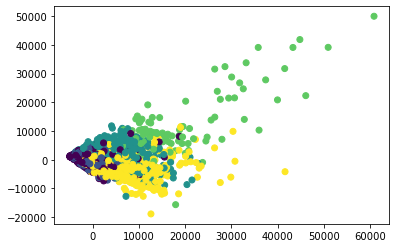

In [17]:
k = 5
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=results_df[f'clusters_kmeans_std{k}']);

In [18]:
components = dict(zip(columns[1:], pca.components_[0]))
components = sorted(components.items(), key=lambda x: x[1], reverse=True)

for c, w in components:
    print(c, np.round(w, 3))

CREDIT_LIMIT 0.687
PAYMENTS 0.488
PURCHASES 0.295
BALANCE 0.291
CASH_ADVANCE 0.217
ONEOFF_PURCHASES 0.213
MINIMUM_PAYMENTS 0.136
INSTALLMENTS_PURCHASES 0.082
PURCHASES_TRX 0.002
CASH_ADVANCE_TRX 0.0
TENURE 0.0
ONEOFF_PURCHASES_FREQUENCY 0.0
PURCHASES_FREQUENCY 0.0
CASH_ADVANCE_FREQUENCY 0.0
PURCHASES_INSTALLMENTS_FREQUENCY 0.0
BALANCE_FREQUENCY 0.0
PRC_FULL_PAYMENT 0.0


# Attempt 1.

Select columns which constitutes the largest variance ratio

In [19]:
selected_cols = ['CREDIT_LIMIT', 'PAYMENTS', 'PURCHASES', 'BALANCE', 'CASH_ADVANCE', 'ONEOFF_PURCHASES', 'MINIMUM_PAYMENTS']

In [20]:
ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='single')

prediction = ac.fit_predict(X_standardized[selected_cols])
np.unique(prediction, return_counts=True)

(array([0, 1]), array([8635,    1]))

In [21]:
ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')

prediction = ac.fit_predict(X_standardized[selected_cols])
np.unique(prediction, return_counts=True)

(array([0, 1]), array([8613,   23]))

# Attempt 2. 

Use PCA representation

In [22]:
pca = PCA(5)
X_pca5 = pca.fit_transform(X_centered[columns[1:]])
print(np.round(pca.explained_variance_ratio_.sum()*100, 2), '%')

95.52 %


In [23]:
ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')

prediction = ac.fit_predict(X_pca5)
np.unique(prediction, return_counts=True)

(array([0, 1]), array([8617,   19]))

# Attempt 3. 

Remove outliers

In [24]:
def detect_outliers_simple(x):
    x = x.values
    q3 = np.quantile(x, 0.75)
    q2 = np.quantile(x, 0.25)
    iqr = q3-q2
    lower_outliers = (q2-1.5*iqr) > x
    upper_outliers = (q3+1.5*iqr) < x
    return lower_outliers + upper_outliers

In [25]:
columns = df.columns

In [26]:
cols_outliers = dict()
outliers = [False] * df.shape[0]

for col in columns[1:]:
        cols_outliers[col] = detect_outliers_simple(df[col])
        outliers += cols_outliers[col]
        print(col, np.round(cols_outliers[col].sum() / df.shape[0] * 100), '%')

BALANCE 8.0 %
BALANCE_FREQUENCY 17.0 %
PURCHASES 9.0 %
ONEOFF_PURCHASES 11.0 %
INSTALLMENTS_PURCHASES 9.0 %
CASH_ADVANCE 11.0 %
PURCHASES_FREQUENCY 0.0 %
ONEOFF_PURCHASES_FREQUENCY 9.0 %
PURCHASES_INSTALLMENTS_FREQUENCY 0.0 %
CASH_ADVANCE_FREQUENCY 4.0 %
CASH_ADVANCE_TRX 9.0 %
PURCHASES_TRX 8.0 %
CREDIT_LIMIT 3.0 %
PAYMENTS 9.0 %
MINIMUM_PAYMENTS 10.0 %
PRC_FULL_PAYMENT 16.0 %
TENURE 15.0 %


In [27]:
X_drop_outliers = X_standardized[~outliers]

In [28]:
X_drop_outliers.shape

(2951, 17)

only ~40% of the data left